# Jane Street - GPU

In [1]:
import gc
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, PrecisionAtRecall
from tensorflow.keras.optimizers import Adam, SGD

# make the x,y labels legible on plots
plt.rc("axes", labelsize=16)

# set tensorflow's random seed
tf.random.set_seed(13)

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)

In [3]:
# split into training and validation
train_df = full_df[full_df["date"].between(0, 350)]
valid_df = full_df[full_df["date"].between(400, 500)]

# fill missing values with median
median = train_df.median()
train_df.fillna(median, inplace=True)
valid_df.fillna(median, inplace=True)

# store imputation values
median.to_csv("impute.csv")

# build features and labels
features = [c for c in train_df.columns if "feature" in c]
train_X = train_df[features].to_numpy()
valid_X = valid_df[features].to_numpy()
train_y = train_df["resp"].gt(1e-4).astype(np.float32).to_numpy()
valid_y = valid_df["resp"].gt(1e-4).astype(np.float32).to_numpy()

# normalize features
#mean = train_X.mean(axis=0)
#std = train_X.std(axis=0)
#train_X = (train_X - mean) / std
#valid_X = (valid_X - mean) / std


print(f"Class imbalance: {train_y.mean()}")

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Class imbalance: 0.5017406940460205


In [4]:
# model training parameters
BATCH_SIZE = 4096
LEARNING_RATE = 0.001
EPOCHS = 200
LABEL_SMOOTHING = 0.01
NOISE = 0.1

# show precision at this recall in metrics
METRIC_RECALL = 0.55

In [5]:
# input & normalization
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(train_X)
inputs = layers.Input(shape=[len(features)])
flow = norm(inputs)

flow = layers.GaussianNoise(stddev=NOISE)(flow)

for units in 3 * [40]:
    flow = layers.Dense(units=units)(flow)
    flow = layers.BatchNormalization()(flow)
    flow = layers.Activation(keras.activations.swish)(flow)
    flow = layers.Dropout(rate=0.3)(flow)

flow = layers.Dense(units=1)(flow)
outputs = layers.Activation("sigmoid")(flow)


# optimization parameters
loss = BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING) #"poisson"
optimizer = Adam(learning_rate=LEARNING_RATE)
metrics = [PrecisionAtRecall(recall=METRIC_RECALL, name="p@r"), AUC(name="auc")]

# compile the model and print a summary
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
normalization (Normalization (None, 130)               261       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 130)               0         
_________________________________________________________________
dense (Dense)                (None, 40)                5240      
_________________________________________________________________
batch_normalization (BatchNo (None, 40)                160       
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)               

In [6]:
# define callbacks for learning rate schedule and early stopping
stopping = EarlyStopping(monitor="val_auc",
                         mode="max",
                         patience=20,
                         min_delta=0.001,
                         restore_best_weights=True)

rate = ReduceLROnPlateau(monitor="val_auc",
                         mode="max",
                         factor=0.5,
                         patience=5,
                         min_lr=0.0005,
                         min_delta=0.001)

hist = model.fit(train_X, train_y,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 validation_data=(valid_X, valid_y),
                 callbacks=[rate, stopping])

Epoch 1/200
400/400 [==============================] - 5s 12ms/step - loss: 0.7039 - p@r: 0.5074 - auc: 0.5096 - val_loss: 0.6927 - val_p@r: 0.4999 - val_auc: 0.5171
Epoch 2/200
400/400 [==============================] - 4s 9ms/step - loss: 0.6926 - p@r: 0.5164 - auc: 0.5239 - val_loss: 0.6925 - val_p@r: 0.5044 - val_auc: 0.5209
Epoch 3/200
400/400 [==============================] - 3s 9ms/step - loss: 0.6918 - p@r: 0.5195 - auc: 0.5289 - val_loss: 0.6922 - val_p@r: 0.5044 - val_auc: 0.5237
Epoch 4/200
400/400 [==============================] - 4s 10ms/step - loss: 0.6915 - p@r: 0.5219 - auc: 0.5323 - val_loss: 0.6921 - val_p@r: 0.5051 - val_auc: 0.5260
Epoch 5/200
400/400 [==============================] - 4s 10ms/step - loss: 0.6912 - p@r: 0.5230 - auc: 0.5343 - val_loss: 0.6920 - val_p@r: 0.5061 - val_auc: 0.5268
Epoch 6/200
400/400 [==============================] - 4s 9ms/step - loss: 0.6910 - p@r: 0.5241 - auc: 0.5361 - val_loss: 0.6918 - val_p@r: 0.5083 - val_auc: 0.5277
Epoch 7

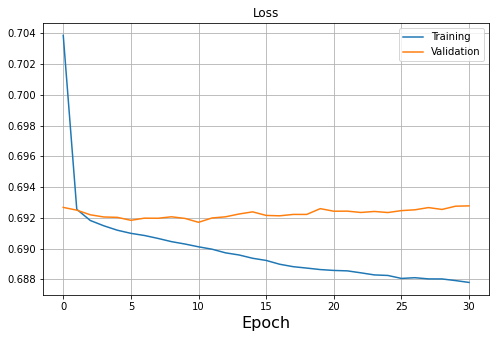

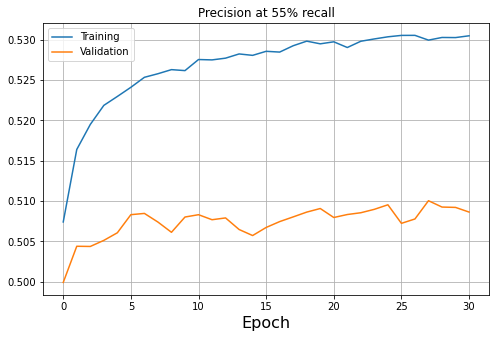

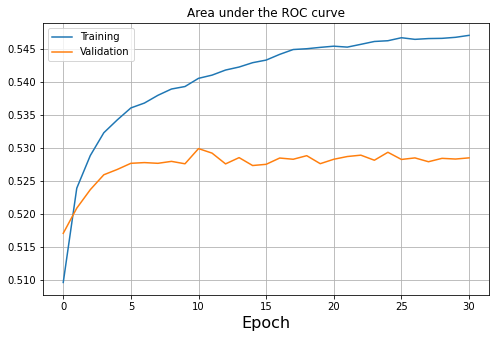

In [7]:
hist_df = pd.DataFrame(hist.history)

# loss
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["loss"], label="Training")
sns.lineplot(data=hist_df["val_loss"], label="Validation")
plt.title("Loss")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# precision at recall
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["p@r"], label="Training")
sns.lineplot(data=hist_df["val_p@r"], label="Validation")
plt.title(f"Precision at {int(100 * METRIC_RECALL)}% recall")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# area under ROC curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["auc"], label="Training")
sns.lineplot(data=hist_df["val_auc"], label="Validation")
plt.title("Area under the ROC curve")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

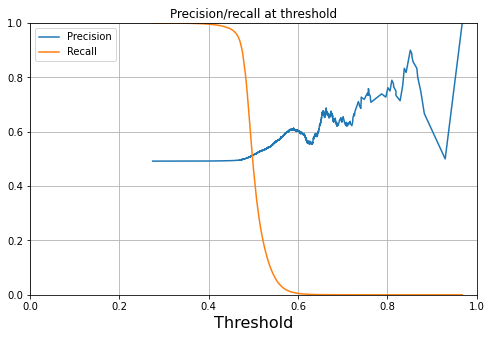

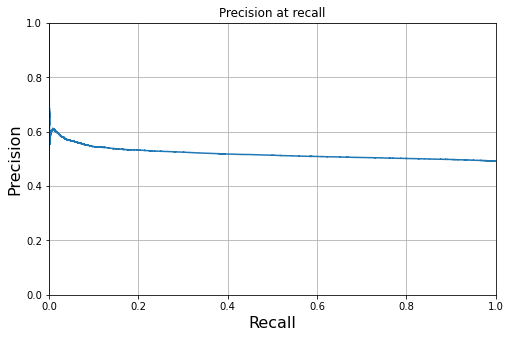

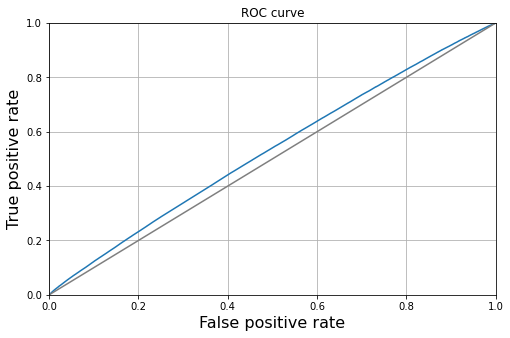

In [8]:
probs = model.predict(valid_X)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

In [9]:
with open("model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("model.h5")